## Amazon US Stock Market Prediction
Predicting future stock market values is a very popular time series problem for machine learning. In this project, I shall attempt to build two LTSM models. One for predicting one-step ahead, and one for multi-steps ahead. The Amazon US stock market data comes from the Huge Stock Market Dataset, containing years of historical stock market data for all US-based stocks. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_absolute_error
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM

In [2]:
data = pd.read_csv("../input/price-volume-data-for-all-us-stocks-etfs/Stocks/amzn.us.txt")
print(data.shape)
data.head()

(5153, 7)


,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0


There are 5153 days recorded for Amazon's stock market values in this dataset. As we can already see from these first 5 rows, the days are not perfectly consecutive, and some days are missing. Hopefully this will not significantly affect the model's accuracy.

In [3]:
data["Date"] = pd.to_datetime(data["Date"])
data = data.drop(["OpenInt"], axis=1)
data.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Thankfully there are no missing values in the dataset, so no data cleaning is required here.

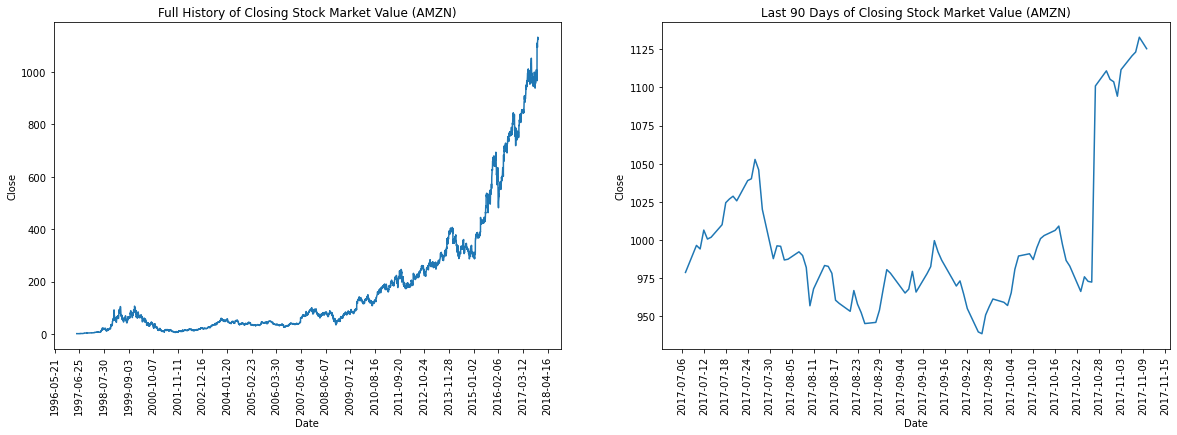

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(x="Date", y="Close", data=data, ax=ax[0])
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=25))
ax[0].set_title("Full History of Closing Stock Market Value (AMZN)")

sns.lineplot(x="Date", y="Close", data=data[-90:], ax=ax[1])
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=25))
ax[1].set_title("Last 90 Days of Closing Stock Market Value (AMZN)")

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

A bit of data visualisation here shows how Amazon's closing stock market value has changed over the last 20 years. We can also see here the last 90 days of closing values recorded in this dataset. The data only goes up until the end of 2017.

# One-Step LTSM Model

In [5]:
WINDOW_LENGTH = 60

The window length determines how many previous days of historical data will be used for the model to make predictions. For the one-step model, in order to predict the closing value on a certain day, the model will use the previous 60 days of data.

In [6]:
split_timestamp = data[-(WINDOW_LENGTH * 2) - 1:]["Date"].iloc[0]

train = data[data["Date"] < split_timestamp]
test = data[data["Date"] >= split_timestamp]

train = train.set_index("Date")
test = test.set_index("Date")

In [7]:
train_values = train.values
test_values = test.values

train_mean = train_values.mean(axis=0)
train_std = train_values.std(axis=0)

train_scaled = (train_values - train_mean) / train_std
test_scaled = (test_values - train_mean) / train_std

In [8]:
x_train = []
for i in range(WINDOW_LENGTH, train.shape[0] - 1):
    x_train.append(train_scaled[(i - WINDOW_LENGTH):i].copy())
x_train = np.array(x_train)
y_train = train_scaled[WINDOW_LENGTH + 1:, 3]
print("X train shape: ", x_train.shape)
print("y train shape: ", y_train.shape)


x_test = []
for i in range(WINDOW_LENGTH, test.shape[0] - 1):
    x_test.append(test_scaled[(i - WINDOW_LENGTH):i].copy())
x_test = np.array(x_test)
y_test = test_scaled[WINDOW_LENGTH + 1:, 3]
print("X test shape: ", x_test.shape)
print("y test shape: ", y_test.shape)

X train shape:  (4971, 60, 5)
y train shape:  (4971,)
X test shape:  (60, 60, 5)
y test shape:  (60,)


In [9]:
model = Sequential()
model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mae", optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(x_train, y_train, batch_size=32, epochs=50, shuffle=True)

Epoch 1/50
156/156 [==============================] - 1s 5ms/step - loss: 0.1057
Epoch 2/50
156/156 [==============================] - 1s 5ms/step - loss: 0.0644
Epoch 3/50
156/156 [==============================] - 1s 5ms/step - loss: 0.0589
Epoch 4/50
156/156 [==============================] - 1s 5ms/step - loss: 0.0560
Epoch 5/50
156/156 [==============================] - 1s 5ms/step - loss: 0.0559
Epoch 6/50
156/156 [==============================] - 1s 5ms/step - loss: 0.0543
Epoch 7/50
156/156 [==============================] - 1s 5ms/step - loss: 0.0544
Epoch 8/50
156/156 [==============================] - 1s 5ms/step - loss: 0.0532
Epoch 9/50
156/156 [==============================] - 1s 5ms/step - loss: 0.0515
Epoch 10/50
156/156 [==============================] - 1s 5ms/step - loss: 0.0527
Epoch 11/50
156/156 [==============================] - 1s 5ms/step - loss: 0.0508
Epoch 12/50
156/156 [==============================] - 1s 5ms/step - loss: 0.0515
Epoch 13/50
156/156 [====

Train MAE: 0.033640031044941725
Test MAE: 0.13173922303562483


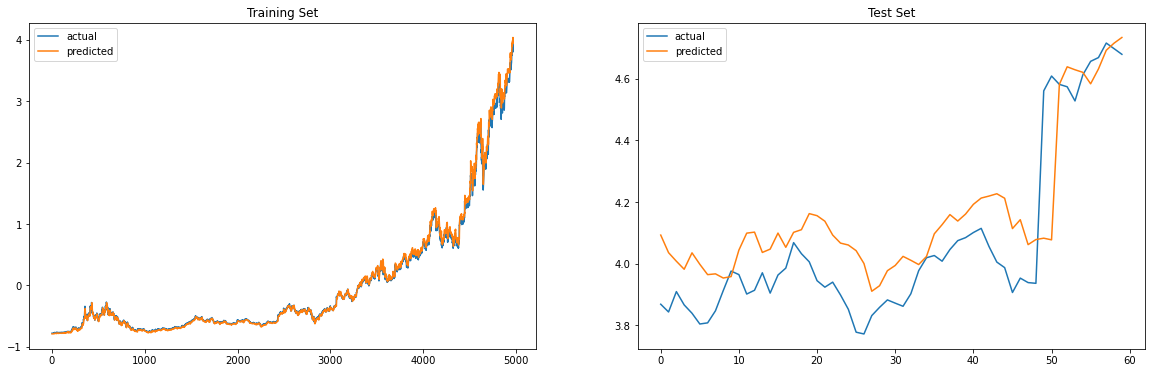

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

y_pred = model.predict(x_train)
ax[0].plot(y_train, label="actual")
ax[0].plot(y_pred, label="predicted")
ax[0].set_title("Training Set")

mae = mean_absolute_error(y_train, y_pred)
print('Train MAE: {}'.format(mae))

y_pred = model.predict(x_test)
ax[1].plot(y_test, label="actual")
ax[1].plot(y_pred, label="predicted")
ax[1].set_title("Test Set")

mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: {}'.format(mae))

for ax in fig.axes:
    plt.sca(ax)
    plt.legend()
plt.show()

With the one-step model, we can see an impressive level of accuracy here. The model's predictions closely resembles the line of the actual closing value. It has also fit nicely to the training data with a very low Mean Absolute Error value. 

# Multi-Step LTSM Model

In [12]:
WINDOW_LENGTH = 60
TARGET_LENGTH = 30

For the multi-step model, we are no longer predicting the closing value for just one day, but multiple days in the future at once. A target length of 30 means the model needs to predict the closing value for the next 30 days, using 60 days of historical data.

In [13]:
x_train = []
y_train = []
for i in range(WINDOW_LENGTH, train.shape[0] - TARGET_LENGTH):
    x_train.append(train_scaled[(i - WINDOW_LENGTH):i].copy())
    y_train.append(train_scaled[i:(i + TARGET_LENGTH), 3].copy())
x_train = np.array(x_train)
y_train = np.array(y_train)
print("X train shape: ", x_train.shape)
print("y train shape: ", y_train.shape)

x_test = []
y_test = []
for i in range(WINDOW_LENGTH, test.shape[0] - TARGET_LENGTH):
    x_test.append(test_scaled[(i - WINDOW_LENGTH):i].copy())
    y_test.append(test_scaled[i:(i + TARGET_LENGTH), 3].copy())
x_test = np.array(x_test)
y_test = np.array(y_test)
print("X test shape: ", x_test.shape)
print("y test shape: ", y_test.shape)

X train shape:  (4942, 60, 5)
y train shape:  (4942, 30)
X test shape:  (31, 60, 5)
y test shape:  (31, 30)


In [14]:
model = Sequential()
model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(TARGET_LENGTH))

model.compile(loss="mae", optimizer="adam")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(x_train, y_train, batch_size=32, epochs=50, shuffle=True)

Epoch 1/50
155/155 [==============================] - 1s 5ms/step - loss: 0.1956
Epoch 2/50
155/155 [==============================] - 1s 5ms/step - loss: 0.0808
Epoch 3/50
155/155 [==============================] - 1s 5ms/step - loss: 0.0753
Epoch 4/50
155/155 [==============================] - 1s 5ms/step - loss: 0.0722
Epoch 5/50
155/155 [==============================] - 1s 4ms/step - loss: 0.0702
Epoch 6/50
155/155 [==============================] - 1s 5ms/step - loss: 0.0682
Epoch 7/50
155/155 [==============================] - 1s 6ms/step - loss: 0.0656
Epoch 8/50
155/155 [==============================] - 1s 5ms/step - loss: 0.0652
Epoch 9/50
155/155 [==============================] - 1s 5ms/step - loss: 0.0646
Epoch 10/50
155/155 [==============================] - 1s 5ms/step - loss: 0.0632
Epoch 11/50
155/155 [==============================] - 1s 5ms/step - loss: 0.0626
Epoch 12/50
155/155 [==============================] - 1s 5ms/step - loss: 0.0613
Epoch 13/50
155/155 [====

In [16]:
y_pred = model.predict(x_train)
mae = mean_absolute_error(y_train, y_pred)
print('Train MAE: {}'.format(mae))

y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: {}'.format(mae))

Train MAE: 0.04785634314494595
Test MAE: 0.165958712864434


In [17]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))

    plt.plot(np.arange(-WINDOW_LENGTH, 1), np.concatenate((history[:, 3], [true_future[0]])), label='History')
    plt.plot(np.arange(TARGET_LENGTH), true_future, 'b', label='True Future')
    plt.plot(np.arange(TARGET_LENGTH), prediction, 'r', label='Predicted Future')
    plt.legend()
    plt.show()

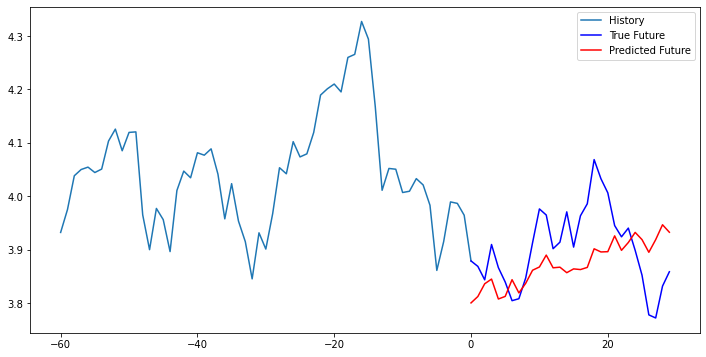

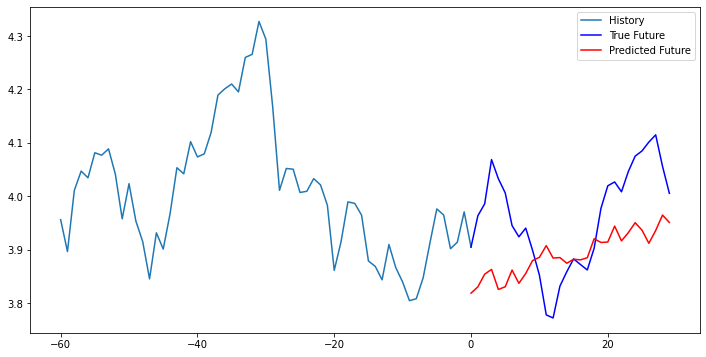

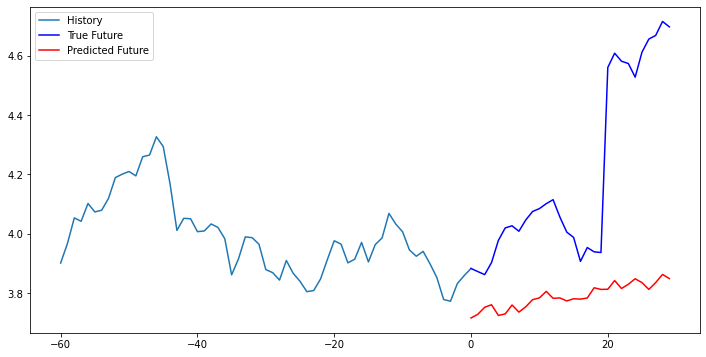

In [18]:
for i in [0, 15, 30]:
    multi_step_plot(x_test[i], y_test[i], y_pred[i])

From these plots we can see that the multi-step model cannot predict the future 30 days very well at all. The MAE of the test set is only slightly higher than that of the one-step model, yet we can clearly see from the three graphs above that the multi-step model struggles to accurately predict a 30 days into the future. 

# Conclusion

In general, Deep Learning models still lag behind old statistical methods like ARIMA when it comes to time series analysis and predicting future forecasts. From this project, I can clearly see that the one-step model appears to perform quite well at predicting the next day's closing value. However the multi-step model is quite a mess at predicting the next 30 days of closing values. The test MAE of the multi-step model is only slightly higher than that of the one-step model, yet you can clearly see quite a difference in the graphs above. This indicates that using MAE as a scoring metric may not be very useful for measuring the model's true accuracy.

In future, it would be interesting to try out different window lengths, target lengths and LTSM models to see how the prediction can be improved for the multi-step model in particular. It could be the case that using too much historical data adds a lot of noise that the model overfits to. 